In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from src.features.feature_engineering_1 import *
from src.features.q3_plots import *
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score
import joblib

In [2]:
import os
from dotenv import load_dotenv
from comet_ml import Experiment
load_dotenv('..\.env')

True

In [3]:
try:
    if not os.path.exists("..\data\models"):
        os.mkdir("..\data\models")
except OSError:
    print("Erreur lors de la création du répertoire")

In [4]:
# Définition des années de train
years_train = ['2016', '2017', '2018', '2019']

In [5]:
# Chargement des données d'entrainement
data = get_all_season_data(years_train)
data.head()

,period,period_type,period_time,gameID,attacking_team_id,attacking_team_name,play_type,shooter,goalie,shot_type,x_coordinate,y_coordinate,empty_net,strength,last_event_type,last_event_x,last_event_y,time_since_last_event,distance_from_last_event
0,1,REGULAR,01:11,2016020001,10,Toronto Maple Leafs,Shot,Mitchell Marner,Craig Anderson,Wrist Shot,-77.0,5.0,NaN,NaN,Blocked Shot,-61.0,11.0,1,17.088007
1,1,REGULAR,02:53,2016020001,9,Ottawa Senators,Shot,Chris Kelly,Frederik Andersen,Wrist Shot,86.0,13.0,NaN,NaN,Giveaway,54.0,-5.0,5,36.715120
2,1,REGULAR,04:01,2016020001,9,Ottawa Senators,Shot,Cody Ceci,Frederik Andersen,Wrist Shot,23.0,-38.0,NaN,NaN,Missed Shot,-72.0,0.0,18,102.318131
3,1,REGULAR,04:46,2016020001,9,Ottawa Senators,Shot,Erik Karlsson,Frederik Andersen,Slap Shot,33.0,-15.0,NaN,NaN,Missed Shot,77.0,-2.0,19,45.880279
4,1,REGULAR,06:46,2016020001,10,Toronto Maple Leafs,Shot,Martin Marincin,Craig Anderson,Wrist Shot,-34.0,28.0,NaN,NaN,Hit,47.0,34.0,16,81.221918


In [6]:
# Ajout des features de distance et d'angle
data = add_new_features(data)
data.head()

,period,period_type,period_time,gameID,attacking_team_id,attacking_team_name,play_type,shooter,goalie,shot_type,...,strength,last_event_type,last_event_x,last_event_y,time_since_last_event,distance_from_last_event,distance_to_net,shot_angle,is_goal,is_empty_net
0,1,REGULAR,01:11,2016020001,10,Toronto Maple Leafs,Shot,Mitchell Marner,Craig Anderson,Wrist Shot,...,NaN,Blocked Shot,-61.0,11.0,1,17.088007,13.0,23.0,0,0
1,1,REGULAR,02:53,2016020001,9,Ottawa Senators,Shot,Chris Kelly,Frederik Andersen,Wrist Shot,...,NaN,Giveaway,54.0,-5.0,5,36.715120,13.0,77.0,0,0
2,1,REGULAR,04:01,2016020001,9,Ottawa Senators,Shot,Cody Ceci,Frederik Andersen,Wrist Shot,...,NaN,Missed Shot,-72.0,0.0,18,102.318131,76.0,-30.0,0,0
3,1,REGULAR,04:46,2016020001,9,Ottawa Senators,Shot,Erik Karlsson,Frederik Andersen,Slap Shot,...,NaN,Missed Shot,77.0,-2.0,19,45.880279,58.0,-15.0,0,0
4,1,REGULAR,06:46,2016020001,10,Toronto Maple Leafs,Shot,Martin Marincin,Craig Anderson,Wrist Shot,...,NaN,Hit,47.0,34.0,16,81.221918,62.0,27.0,0,0


In [7]:
# Sélection de la caractéristique distance_to_net et des labels is_goal
df1 = data[['distance_to_net', 'is_goal']]
df1.head()

,distance_to_net,is_goal
0,13.0,0
1,13.0,0
2,76.0,0
3,58.0,0
4,62.0,0


In [8]:
# Suppression des valeurs NaN
df1 = df1.dropna()

In [9]:
y1 = df1['is_goal'].values
X1 = df1['distance_to_net'].values

In [10]:
# Split des données d'entrainement en train et val
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2)

# Reshpae des array
X_train1 = X_train1.reshape(X_train1.shape[0], 1)
X_val1 = X_val1.reshape(X_val1.shape[0], 1)

**Question 1**

In [11]:
modele_base1 = LogisticRegression()
modele_base1.fit(X_train1, y_train1)

#save model
joblib.dump(modele_base1, '..\data\models\modele_base_distance.joblib')

['..\\data\\models\\modele_base_distance.joblib']

In [12]:
# Prédiction des données de val
y_pred1 = modele_base1.predict(X_val1)

In [13]:
confusion_matrix(y_val1, y_pred1)

array([[59361,     0],
       [ 6104,     0]], dtype=int64)

In [14]:
accuracy1 = accuracy_score(y_val1, modele_base1.predict(X_val1))
recall1 = recall_score(y_val1, modele_base1.predict(X_val1))
f1_score1 = f1_score(y_val1, modele_base1.predict(X_val1))
auc1 = roc_auc_score(y_val1, modele_base1.predict_proba(X_val1)[:, 1])

print('Accuracy :', accuracy1)
print('Recall :', recall1)
print('Recall :', f1_score1)
print('AUC :', auc1)

Accuracy : 0.9067593370503323
Recall : 0.0
Recall : 0.0
AUC : 0.699142277443502


Nous remarquons que la précision du modèle est très bonne. Cependant ce résultat est trompeur car le modèle prédit que tous les exemples de l'ensemble de validation sont de la classe 0 (à l'aide de la matrice de confusion)

En calculant le Recall on se rend compte qu'il vaut 0. C'est un très très mauvais résultat.

Les problèmes possibles sont :
- Pas assez d'exemple de la classe 1 (pour un but)
- Seul la distance ne suffit pas pour prédire correctement 

**Question 2**

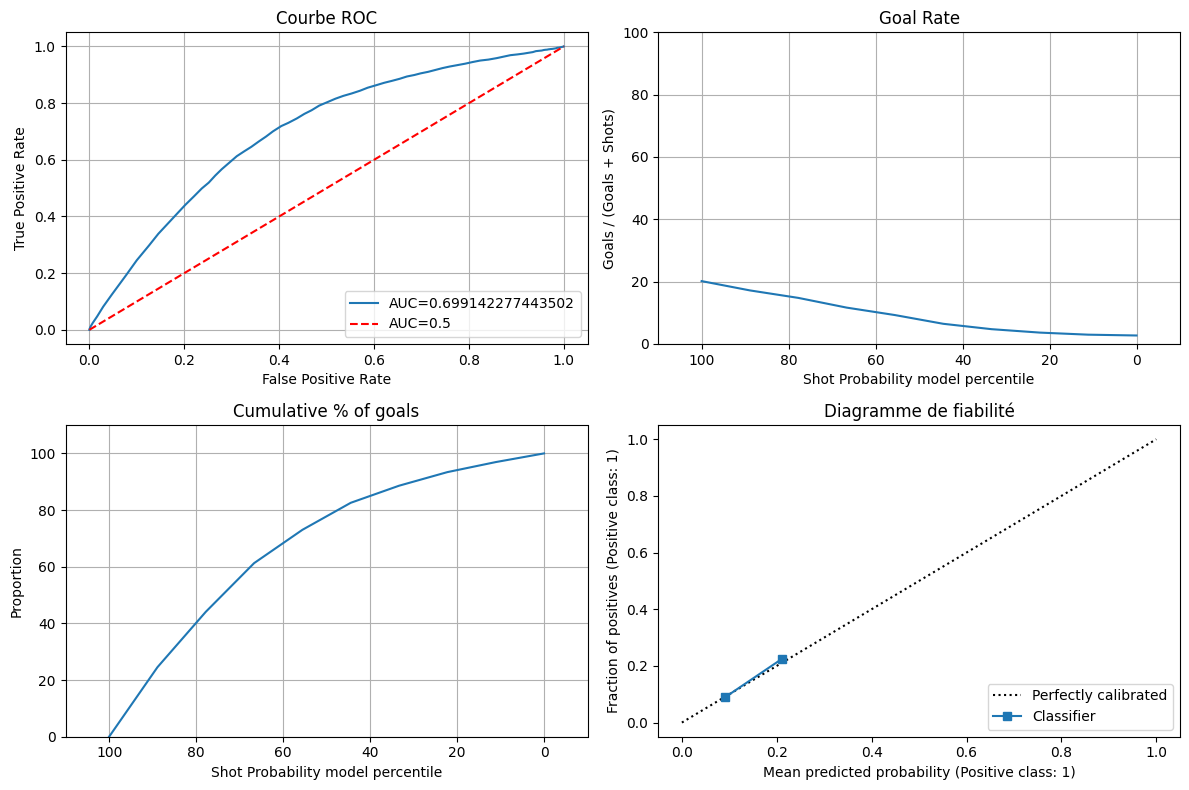

In [15]:
y_pred_proba1 = modele_base1.predict_proba(X_val1)[:, 1]
plot_metrics(y_val1, y_pred_proba1)

$\textbf{Expérience 1: en utilisant la distance}$

In [16]:
experiment1 = Experiment(
    api_key = os.getenv('COMET_API_KEY'),
    project_name="ift6758-project",
    workspace="tedoul",
)

#nommer l'expérience
experiment1.set_name("modele_base with distance")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tedoul/ift6758-project/e38ca4cc9e744cc9adc9662fc5ac4195



In [17]:
#charger les métriques que vous avez calculé
experiment1.log_metrics({"accuracy": accuracy1, "recall": recall1, "f1-score": f1_score1, "auc": auc1})
experiment1.log_confusion_matrix(y_val1, modele_base1.predict(X_val1))

{'web': 'https://www.comet.com/api/asset/download?assetId=181870d553964954b4a07ebb68ba1164&experimentKey=e38ca4cc9e744cc9adc9662fc5ac4195',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=181870d553964954b4a07ebb68ba1164&experimentKey=e38ca4cc9e744cc9adc9662fc5ac4195',
 'assetId': '181870d553964954b4a07ebb68ba1164'}

In [18]:
experiment1.log_figure(figure=plot_roc_curve(y_val1, y_pred_proba1), figure_name="Courbe ROC")
plt.close()
experiment1.log_figure(figure=plot_goal_rate(y_val1, y_pred_proba1), figure_name="Goal rate")
plt.close()
experiment1.log_figure(figure=plot_cumulative_percent_goal(y_val1, y_pred_proba1), figure_name="Cumulative percent of goal")
plt.close()
experiment1.log_figure(figure=plot_fiability_diagram_resize(y_val1, y_pred_proba1), figure_name="Diagrame de fiabilité")
plt.close()


In [19]:
experiment1.log_model(name="mode_base_distance", file_or_folder="..\data\models\modele_base_distance.joblib")
experiment1.add_tags(["regression_logistique", "utilisation de la distance", "version 1"])

In [20]:
experiment1.end

<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x0000026129674FD0>>

**Question 3**

Utilisation de la caractéristique d'angle uniquement

In [21]:
#utilisation de la caractéristique d'angle
df2 = data[['shot_angle', 'is_goal']]
df2 = df2.dropna()
df2.head()

,shot_angle,is_goal
0,23.0,0
1,77.0,0
2,-30.0,0
3,-15.0,0
4,27.0,0


In [22]:
y2 = df2['is_goal'].values
X2 = df2['shot_angle'].values

# Split des données d'entrainement en train et val
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2)

# Reshpae des array
X_train2 = X_train2.reshape(X_train2.shape[0], 1)
X_val2 = X_val2.reshape(X_val2.shape[0], 1)

COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file


In [23]:
modele_base2 = LogisticRegression()
modele_base2.fit(X_train2, y_train2)
joblib.dump(modele_base2, '..\data\models\modele_base_angle.joblib')

COMET WARNING: Unknown error retrieving Conda information


['..\\data\\models\\modele_base_angle.joblib']

In [24]:
accuracy2 = accuracy_score(y_val2, modele_base2.predict(X_val2))
recall2 = recall_score(y_val2, modele_base2.predict(X_val2))
f1_score2 = f1_score(y_val2, modele_base1.predict(X_val2))
auc2 = roc_auc_score(y_val2, modele_base2.predict_proba(X_val2)[:, 1])

print('Accuracy :', accuracy2)
print('Recall :', recall2)
print('Recall :', f1_score2)
print('AUC :', auc2)

Accuracy : 0.9075994806385091
Recall : 0.0
Recall : 0.11680303091370763
AUC : 0.5053774771639082


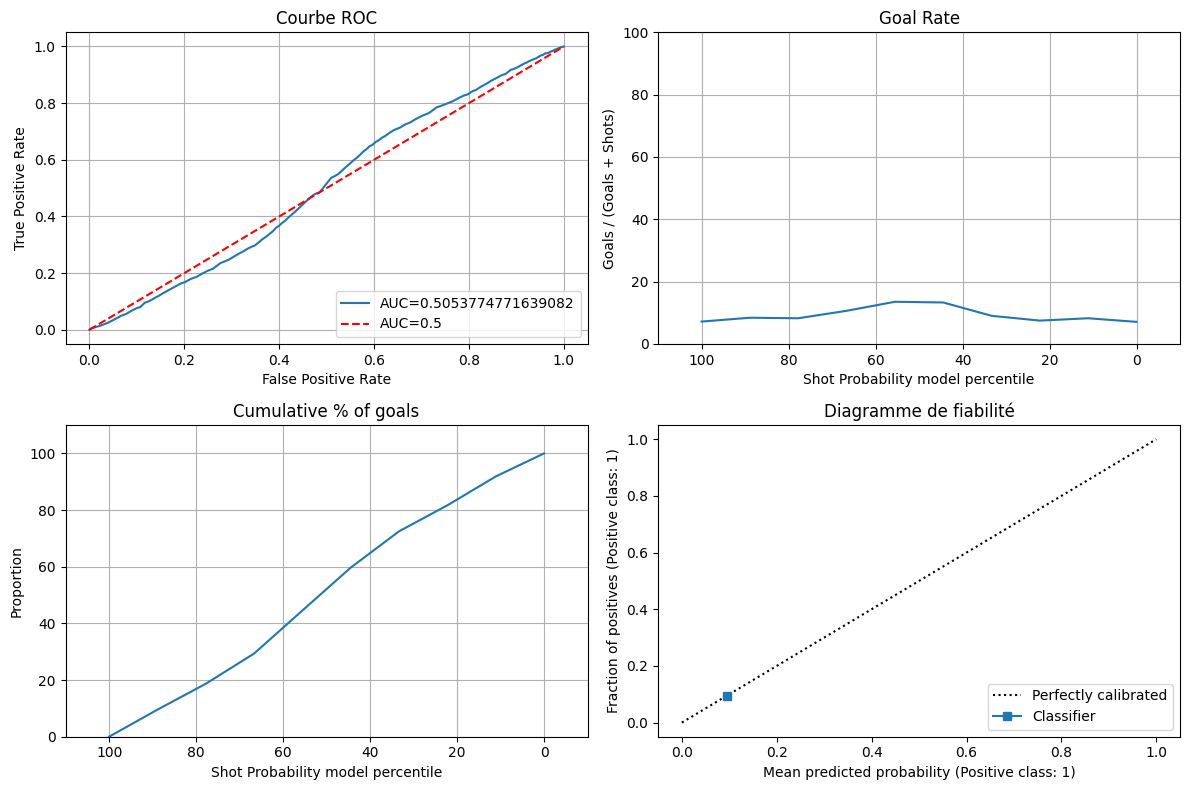

In [25]:
y_pred_proba2 = modele_base2.predict_proba(X_val2)[:, 1]
plot_metrics(y_val2, y_pred_proba2)

$\textbf{Expérience 2: Utilisation de l'angle}$

In [26]:
experiment2 = Experiment(
    api_key = os.getenv('COMET_API_KEY'),
    project_name="ift6758-project",
    workspace="tedoul",
)

#nommer l'expérience
experiment2.set_name("modele_base with angle")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tedoul/ift6758-project/e38ca4cc9e744cc9adc9662fc5ac4195
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.9067593370503323
COMET INFO:     auc      : 0.699142277443502
COMET INFO:     f1-score : 0.0
COMET INFO:     recall   : 0.0
COMET INFO:   Others:
COMET INFO:     Name : modele_base with distance
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET INFO:     git me

COMET INFO:     model-element            : 1 (879 bytes)
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tedoul/ift6758-project/790eb23698eb454eb77760c7a448ea61



In [27]:
#charger les métriques que vous avez calculé
experiment2.log_metrics({"accuracy": accuracy2, "recall": recall2, "f1-score": f1_score2, "auc": auc2})
experiment2.log_confusion_matrix(y_val2, modele_base2.predict(X_val2))

{'web': 'https://www.comet.com/api/asset/download?assetId=9a9daf222a1e4a22b69a7a74f5ffe1f9&experimentKey=790eb23698eb454eb77760c7a448ea61',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=9a9daf222a1e4a22b69a7a74f5ffe1f9&experimentKey=790eb23698eb454eb77760c7a448ea61',
 'assetId': '9a9daf222a1e4a22b69a7a74f5ffe1f9'}

COMET WARNING: Unknown error exporting current conda environment


In [28]:
experiment2.log_figure(figure=plot_roc_curve(y_val2, y_pred_proba2), figure_name="Courbe ROC")
plt.close()
experiment2.log_figure(figure=plot_goal_rate(y_val2, y_pred_proba2), figure_name="Goal rate")
plt.close()
experiment2.log_figure(figure=plot_cumulative_percent_goal(y_val2, y_pred_proba2), figure_name="Cumulative percent of goal")
plt.close()
experiment2.log_figure(figure=plot_fiability_diagram_resize(y_val2, y_pred_proba2), figure_name="Diagrame de fiabilité")
plt.close()


COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


COMET WARNING: Unknown error retrieving Conda package as an explicit file


COMET WARNING: Unknown error retrieving Conda information


In [29]:
experiment2.log_model(name="mode_base_angle", file_or_folder="..\data\models\modele_base_angle.joblib")
experiment2.add_tags(["regression_logistique", "utilisation de l'angle", "version 1"])

In [30]:
experiment2.end

<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x000002612DC9E040>>

Utilisation de la caractéristique d'angle et distance

In [31]:
#utilisation de la caractéristique d'angle
df3 = data[['distance_to_net', 'shot_angle', 'is_goal']]
df3 = df3.dropna()
df3.head()

,distance_to_net,shot_angle,is_goal
0,13.0,23.0,0
1,13.0,77.0,0
2,76.0,-30.0,0
3,58.0,-15.0,0
4,62.0,27.0,0


In [32]:
y3 = df3['is_goal'].values
X3 = df3[['distance_to_net', 'shot_angle']].values

# Split des données d'entrainement en train et val
X_train3, X_val3, y_train3, y_val3 = train_test_split(X3, y3, test_size=0.2)

In [33]:
modele_base3 = LogisticRegression()
modele_base3.fit(X_train3, y_train3)
joblib.dump(modele_base3, '..\data\models\modele_base_dist_angle.joblib')

['..\\data\\models\\modele_base_dist_angle.joblib']

In [34]:
accuracy3 = accuracy_score(y_val3, modele_base3.predict(X_val3))
recall3 = recall_score(y_val3, modele_base3.predict(X_val3))
f1_score3 = f1_score(y_val3, modele_base3.predict(X_val3))
auc3 = roc_auc_score(y_val3, modele_base3.predict_proba(X_val3)[:, 1])

print('Accuracy :', accuracy3)
print('Recall :', recall3)
print('Recall :', f1_score3)
print('AUC :', auc3)

Accuracy : 0.906056671503857
Recall : 0.0
Recall : 0.0
AUC : 0.6932894502206423


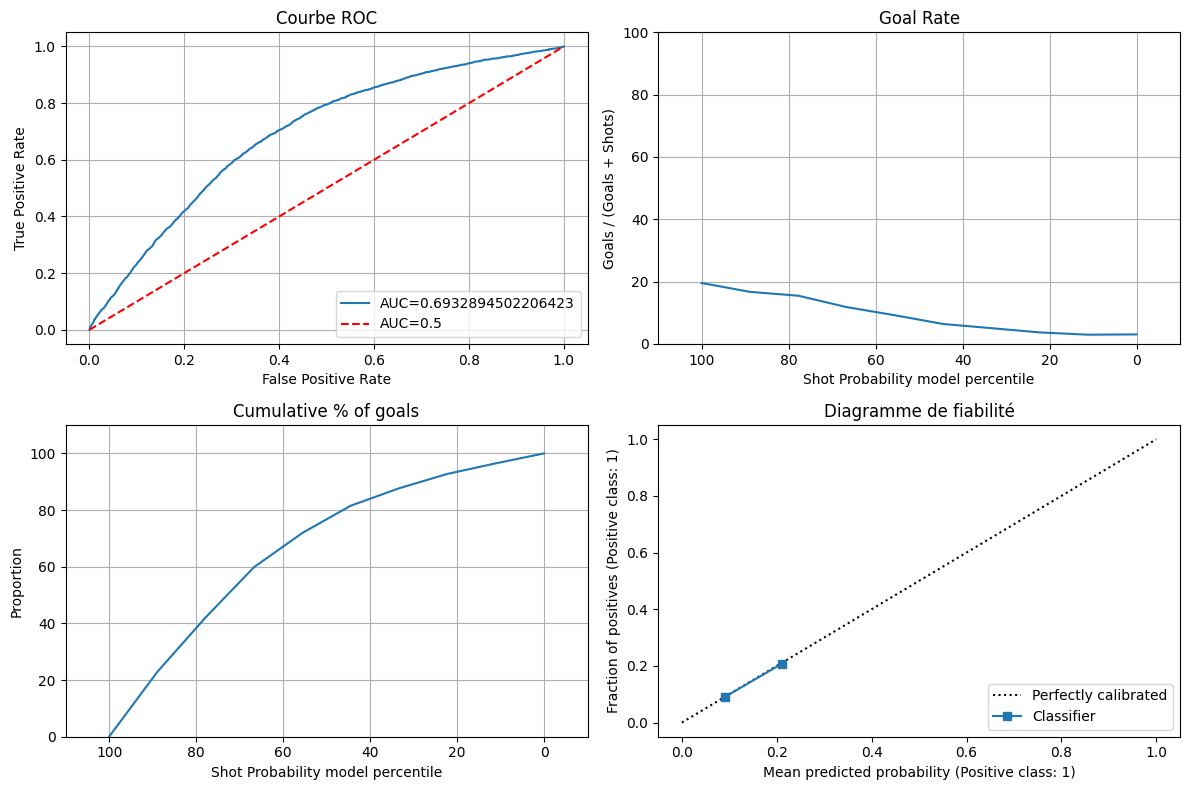

In [35]:
y_pred_proba3 = modele_base3.predict_proba(X_val3)[:, 1]
plot_metrics(y_val3, y_pred_proba3)

$\textbf{Expérience 3: Utilisation de la distance + l'angle}$

In [36]:
experiment3 = Experiment(
    api_key = os.getenv('COMET_API_KEY'),
    project_name="ift6758-project",
    workspace="tedoul",
)

#nommer l'expérience
experiment3.set_name("modele_base with distance and angle")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tedoul/ift6758-project/790eb23698eb454eb77760c7a448ea61
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.9075994806385091
COMET INFO:     auc      : 0.5053774771639082
COMET INFO:     f1-score : 0.11680303091370763
COMET INFO:     recall   : 0.0
COMET INFO:   Others:
COMET INFO:     Name : modele_base with angle
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET IN

In [37]:
#charger les métriques que vous avez calculé
experiment3.log_metrics({"accuracy": accuracy3, "recall": recall3, "f1-score": f1_score3, "auc": auc3})
experiment3.log_confusion_matrix(y_val3, modele_base3.predict(X_val3))

{'web': 'https://www.comet.com/api/asset/download?assetId=a380358be47947d5bc6891b880b688e9&experimentKey=accc3d75648e462d84318411db78c336',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=a380358be47947d5bc6891b880b688e9&experimentKey=accc3d75648e462d84318411db78c336',
 'assetId': 'a380358be47947d5bc6891b880b688e9'}

In [38]:
experiment3.log_figure(figure=plot_roc_curve(y_val3, y_pred_proba3), figure_name="Courbe ROC")
plt.close()
experiment3.log_figure(figure=plot_goal_rate(y_val3, y_pred_proba3), figure_name="Goal rate")
plt.close()
experiment3.log_figure(figure=plot_cumulative_percent_goal(y_val3, y_pred_proba3), figure_name="Cumulative percent of goal")
plt.close()
experiment3.log_figure(figure=plot_fiability_diagram_resize(y_val3, y_pred_proba3), figure_name="Diagrame de fiabilité")
plt.close()


COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


In [39]:
experiment3.log_model(name="mode_base_dist_angle", file_or_folder="..\data\models\modele_base_dist_angle.joblib")
experiment3.add_tags(["regression_logistique", "utilisation de la distance et angle", "version 1"])

In [40]:
experiment3.end

<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x0000026130804F40>>

$\textbf{Ligne de base aléatoire}$

In [41]:
random_proba = np.random.uniform(0, 1, len(y_val3))

In [42]:
y_pred_proba4 = (random_proba > 0.5) * 1
print(accuracy_score(y_val3, y_pred_proba4))

0.4989230886733369


In [43]:
accuracy4 = accuracy_score(y_val3, y_pred_proba4)
recall4 = recall_score(y_val3, y_pred_proba4)
f1_score4 = f1_score(y_val3, y_pred_proba4)
auc4 = roc_auc_score(y_val3, random_proba)

print('Accuracy :', accuracy4)
print('Recall :', recall4)
print('Recall :', f1_score4)
print('AUC :', auc4)

Accuracy : 0.4989230886733369
Recall : 0.49626016260162603
Recall : 0.15688693551288974
AUC : 0.49707470587308084


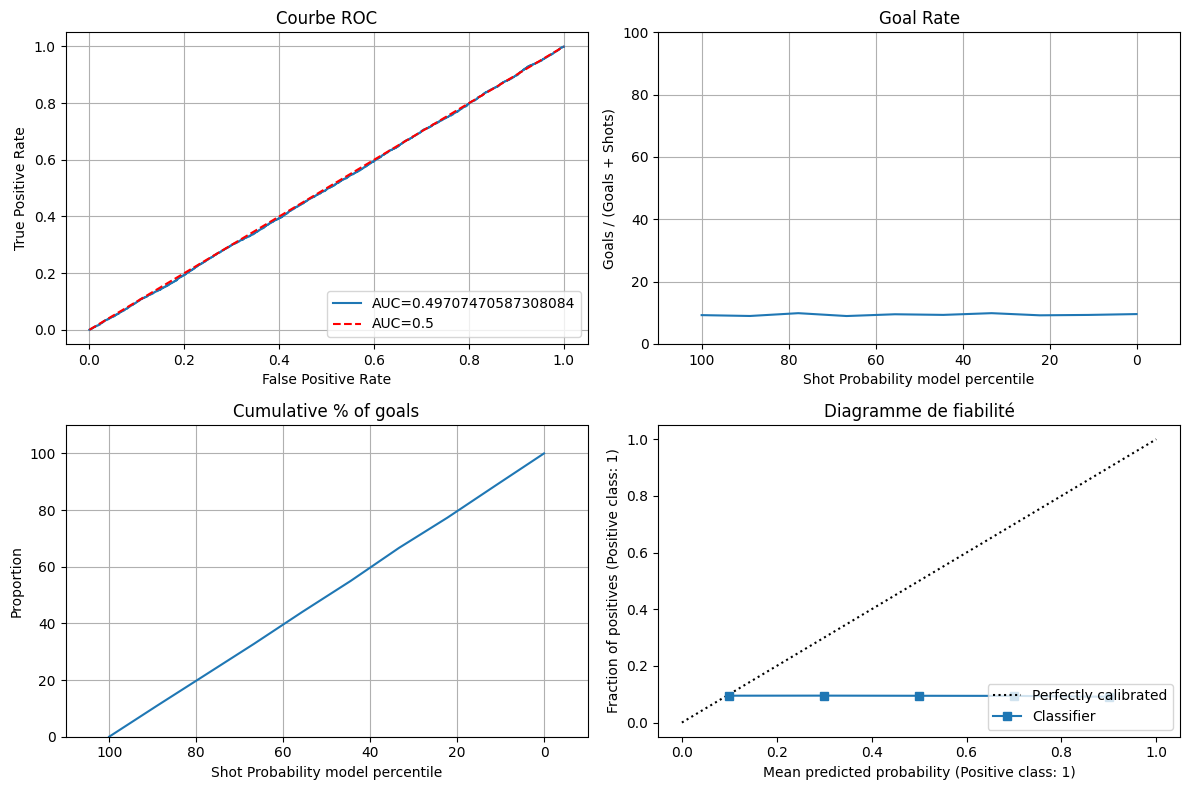

In [44]:
plot_metrics(y_val3, random_proba)

$\textbf{Expérience 4: Random baseline}$

In [45]:
experiment4 = Experiment(
    api_key = os.getenv('COMET_API_KEY'),
    project_name="ift6758-project",
    workspace="tedoul",
)

#nommer l'expérience
experiment4.set_name("random baseline")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tedoul/ift6758-project/accc3d75648e462d84318411db78c336
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.906056671503857
COMET INFO:     auc      : 0.6932894502206423
COMET INFO:     f1-score : 0.0
COMET INFO:     recall   : 0.0
COMET INFO:   Others:
COMET INFO:     Name : modele_base with distance and angle
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET INFO: 

In [46]:
#charger les métriques que vous avez calculé
experiment4.log_metrics({"accuracy": accuracy4, "recall": recall4, "f1-score": f1_score4, "auc": auc4})
experiment4.log_confusion_matrix(y_val3, y_pred_proba4)

{'web': 'https://www.comet.com/api/asset/download?assetId=66e20c4d4f93473e9ab2463f0762b292&experimentKey=da61cbd8251740b9958755d31f4aa05a',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=66e20c4d4f93473e9ab2463f0762b292&experimentKey=da61cbd8251740b9958755d31f4aa05a',
 'assetId': '66e20c4d4f93473e9ab2463f0762b292'}

In [47]:
experiment4.log_figure(figure=plot_roc_curve(y_val3, random_proba), figure_name="Courbe ROC")
plt.close()
experiment4.log_figure(figure=plot_goal_rate(y_val3, random_proba), figure_name="Goal rate")
plt.close()
experiment4.log_figure(figure=plot_cumulative_percent_goal(y_val3, random_proba), figure_name="Cumulative percent of goal")
plt.close()
experiment4.log_figure(figure=plot_fiability_diagram_resize(y_val3, random_proba), figure_name="Diagrame de fiabilité")
plt.close()

COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


In [48]:
experiment4.end

<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x00000261307CA820>>

$\text{Superposition de toutes les courbes}$

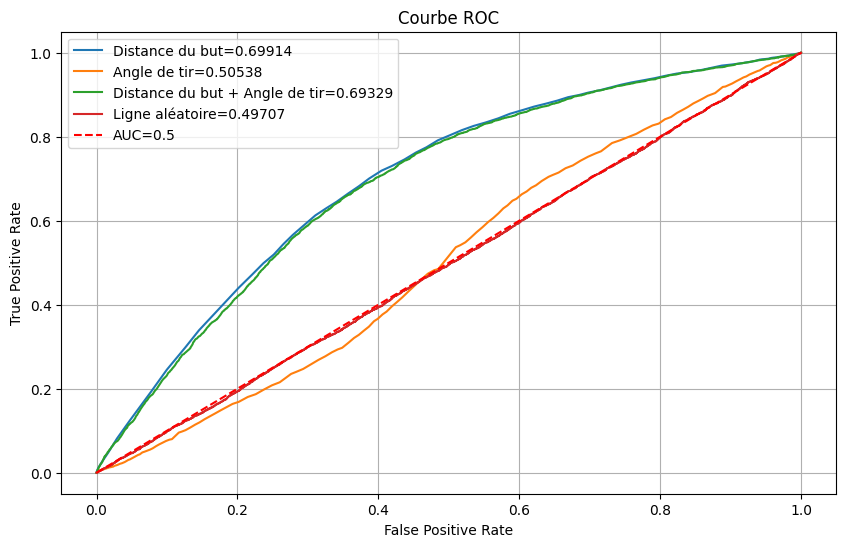

In [49]:
list_y_val = [y_val1, y_val2, y_val3, y_val3]
list_y_proba = [y_pred_proba1, y_pred_proba2, y_pred_proba3, random_proba]
models = ['Distance du but', 'Angle de tir', 'Distance du but + Angle de tir', 'Ligne aléatoire']

plot_all_roc_curve(list_y_val, list_y_proba, models)

Plus l'AUC est proche de 1, meilleure est la performance du modèle. Dans ce cas en utilisant à la fois les caractéristiques de distance et d'angle, le modèle entrainé est le plus performant que si on l'avait entrainé en utilisant soit la distance soit l'angle.

Toutefois nous remarquons qu'en utilisant seulement la caractéristique de distance, les performances du modèle sont meilleures comparé au modèle entrainé en utilisant seulement la caractéristique d'angle. On pourrait conclure que la distance du but est une caractéristique plus importante que celle de l'angle de tir.

Quand on tire uniformément les probabilité de but, l'AUC est proche de 0.5 ce qui équivaut à prédire au hasard s'il y a but ou pas.

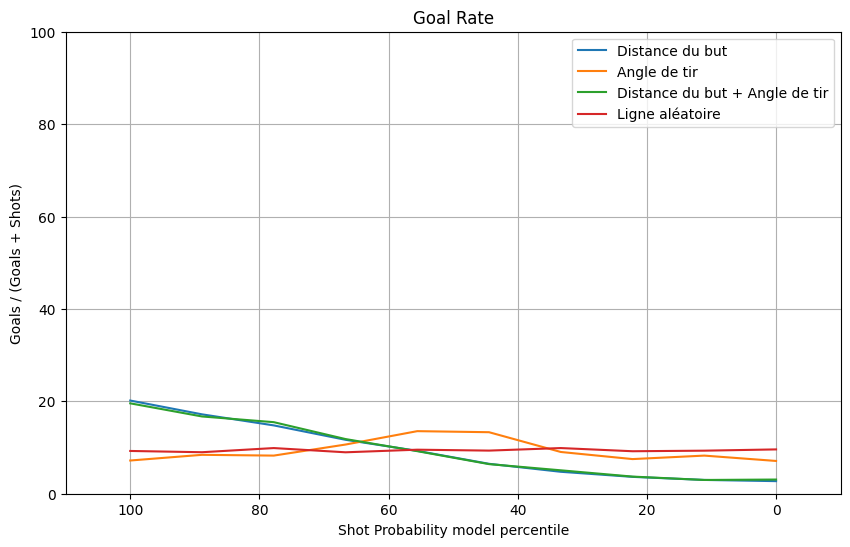

In [50]:
plot_all_goal_rate(list_y_val, list_y_proba, models)

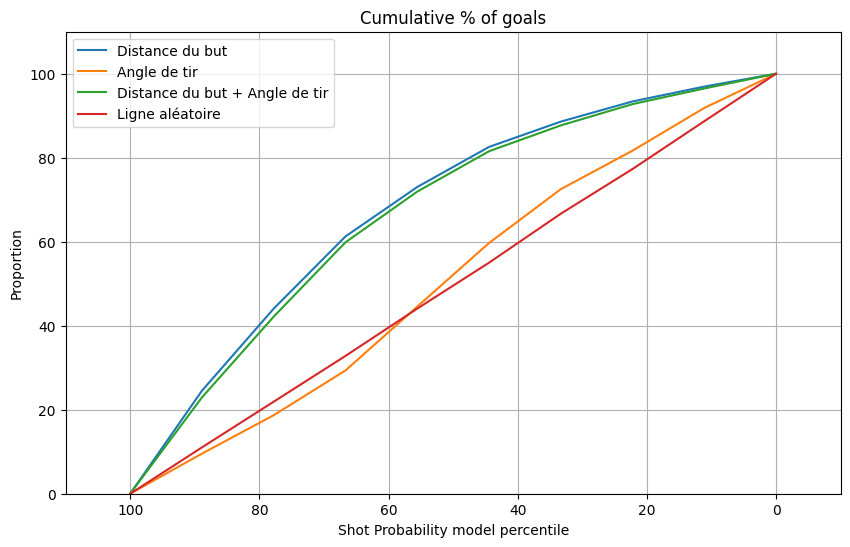

In [51]:
plot_all_cumulative_percent_goal(list_y_val, list_y_proba, models)

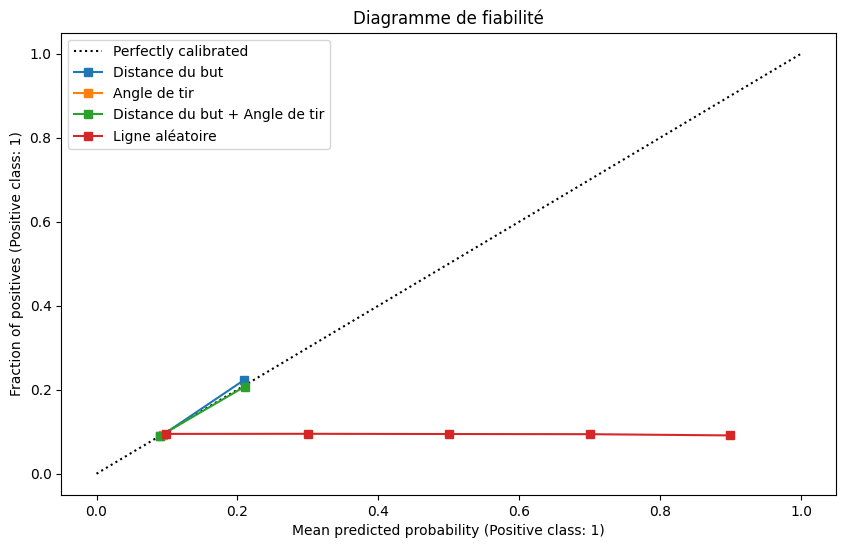

In [52]:
plot_all_fiability_diagram(list_y_val, list_y_proba, models)

$\textbf{Question 4-5}$

In [53]:
data_2017021065 = pd.read_csv('..\data\datasets\csv_files\\2017021065.csv')

In [54]:
experiment = Experiment(
    api_key = os.getenv('COMET_API_KEY'),
    project_name="ift6758-project",
    workspace="tedoul",
)

experiment.set_name('wpg_v_wsh_2017021065')

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tedoul/ift6758-project/da61cbd8251740b9958755d31f4aa05a
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.4989230886733369
COMET INFO:     auc      : 0.49707470587308084
COMET INFO:     f1-score : 0.15688693551288974
COMET INFO:     recall   : 0.49626016260162603
COMET INFO:   Others:
COMET INFO:     Name : random baseline
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tedoul/ift6758-project/2892a0cbe1ab43d5b8f638383b61dcda



In [55]:
experiment.log_dataframe_profile(
data_2017021065, 
name='wpg_v_wsh_2017021065',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)


COMET WARNING: pandas_profiling is required to log profile; ignoring


{'profile': None,
 'dataframe': {'web': 'https://www.comet.com/api/asset/download?assetId=c003cb2600e54496838a17a56886f518&experimentKey=2892a0cbe1ab43d5b8f638383b61dcda',
  'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=c003cb2600e54496838a17a56886f518&experimentKey=2892a0cbe1ab43d5b8f638383b61dcda',
  'assetId': 'c003cb2600e54496838a17a56886f518'}}

In [56]:
experiment.end

COMET WARNING: Unknown error exporting current conda environment


<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x000002612C2F3E50>>

COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information
